# MNIST Handwritten Digit Recognition with Grad-CAM

## Introduction
This project demonstrates an advanced implementation of a handwritten digit recognition system using the MNIST dataset and a Convolutional Neural Network (CNN). The project includes data loading, preprocessing, data augmentation, model building, hyperparameter tuning, training, evaluation, and Grad-CAM visualization to highlight the regions of the images that contribute most to the model's predictions.

## Setup and Imports

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import keras_tuner as kt
from sklearn.manifold import TSNE
import cv2


## Load and Preprocess Data

In [4]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


## Data Augmentation

In [7]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(hp.Int('conv_3_filter', min_value=32, max_value=128, step=32), kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=128, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Model Building

In [8]:

tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='output', project_name='mnist_tuning')
tuner.search(x_train, y_train, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 01m 09s]
val_accuracy: 0.9925000071525574

Best val_accuracy So Far: 0.9925000071525574
Total elapsed time: 00h 07m 25s


## Hyperparameter Tuning

In [11]:

history = best_model.fit(datagen.flow(x_train, y_train, batch_size=128), validation_data=(x_test, y_test), epochs=50, callbacks=[early_stopping, reduce_lr, lr_scheduler])


Epoch 1/50
469/469 [==============================] - 48s 96ms/step - loss: 0.1055 - accuracy: 0.9689 - val_loss: 0.0180 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 2/50
469/469 [==============================] - 22s 47ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.0169 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 3/50
469/469 [==============================] - 24s 51ms/step - loss: 0.0532 - accuracy: 0.9829 - val_loss: 0.0163 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 4/50
469/469 [==============================] - 24s 50ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0148 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 5/50
469/469 [==============================] - 23s 49ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.0175 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 6/50
469/469 [==============================] - 22s 47ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.0148 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 7/50
469/469 [==============================] - 23s 

## Visualization of Model Accuracy and Model loss


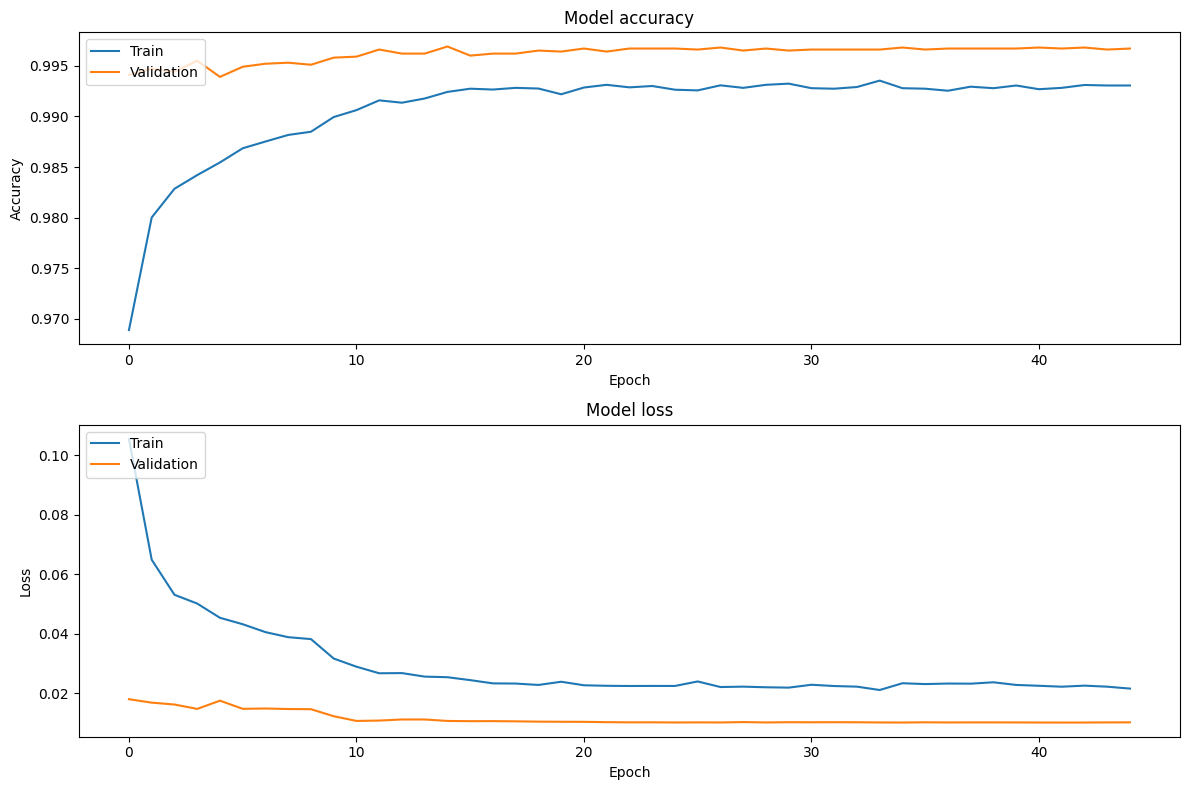

In [16]:

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## t-SNE Visualization of MNIST Test data

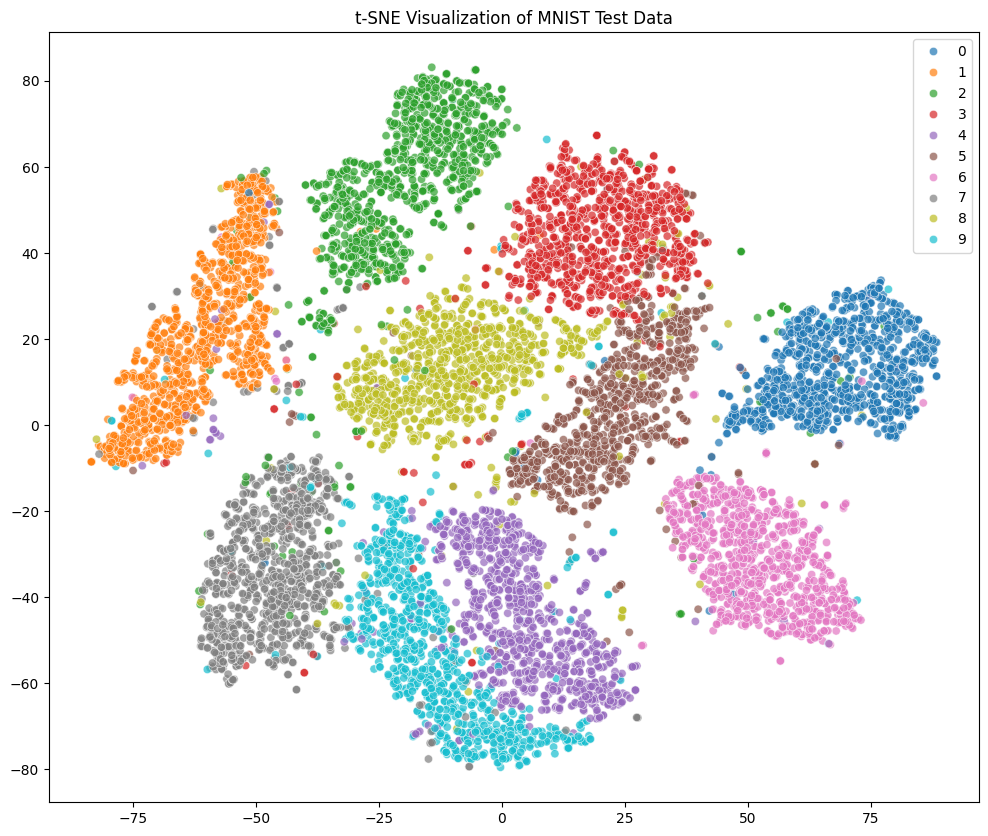

In [18]:

x_test_flat = x_test.reshape(x_test.shape[0], -1)
tsne = TSNE(n_components=2, random_state=42)
x_test_2d = tsne.fit_transform(x_test_flat)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=x_test_2d[:,0], y=x_test_2d[:,1], hue=y_true, palette='tab10', legend='full', alpha=0.7)
plt.title('t-SNE Visualization of MNIST Test Data')
plt.show()


## Grad-CAM Heatmap

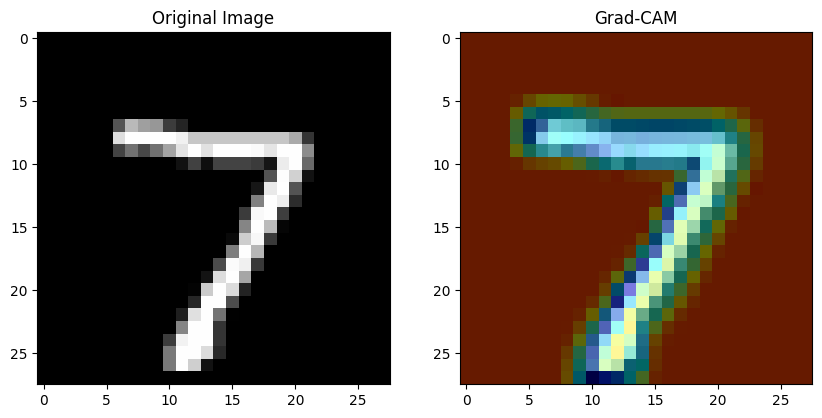

In [24]:
def get_gradcam_heatmap(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("conv2d").output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_array, heatmap, alpha=0.4):
    img = img_array[0].squeeze()
    img_rgb = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img_rgb, 1 - alpha, 0)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.show()

img = x_test[0].reshape(1, 28, 28, 1)
class_idx = np.argmax(y_test[0])
heatmap = get_gradcam_heatmap(best_model, img, class_idx)
display_gradcam(img, heatmap)